<a href="https://colab.research.google.com/github/jpti89/MM-RAG/blob/main/Google_Gemini_multimodal_rag_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal Retrieval Augmented Generation (RAG) using Vertex AI Gemini API

| | |
|-|-|
|Original Author | [Lavi Nigam](https://github.com/lavinigam-gcp) |

### Install Vertex AI SDK for Python and other dependencies


In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform pymupdf

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Define Google Cloud project information


In [ ]:
# Define project information

import sys

PROJECT_ID = "mmragtest"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# if not running on colab, try to get the PROJECT_ID automatically
if "google.colab" not in sys.modules:
    import subprocess

    PROJECT_ID = subprocess.check_output(
        ["gcloud", "config", "get-value", "project"], text=True
    ).strip()

print(f"Your project ID is: {PROJECT_ID}")

In [ ]:
import sys

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries


In [ ]:
from IPython.display import Markdown, display
from vertexai.generative_models import (
    Content,
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    HarmCategory,
    HarmBlockThreshold,
    Image,
    Part,
)

### Load the Gemini 1.0 Pro and Gemini 1.0 Pro Vision model


In [ ]:
text_model = GenerativeModel("gemini-1.0-pro")
multimodal_model = GenerativeModel("gemini-1.0-pro-vision")

### Download custom Python modules and utilities

The cell below will download some helper functions needed for this notebook, to improve readability. You can also view the code (`intro_multimodal_rag_utils.py`) directly on [Github](https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/utils/intro_multimodal_rag_utils.py).

In [ ]:
import os
import urllib.request
import sys

if not os.path.exists("utils"):
    os.makedirs("utils")


# download the helper scripts from utils folder
url_prefix = "https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/utils/"
files = ["intro_multimodal_rag_utils.py"]

for fname in files:
    urllib.request.urlretrieve(f"{url_prefix}/{fname}", filename=f"utils/{fname}")

#### Get documents and images from GCS

In [ ]:
from utils.intro_multimodal_rag_utils import get_document_metadata

### Extract and store metadata of text and images from a document

In [ ]:
# Specify the PDF folder with multiple PDF

# pdf_folder_path = "/content/data/" # if running in Google Colab/Colab Enterprise
pdf_folder_path = "data/"  # if running in Vertex AI Workbench.

# Specify the image description prompt. Change it
image_description_prompt = """Explain what is going on in the image.
If it's a table, extract all elements of the table.
If it's a graph, explain the findings in the graph.
Do not include any numbers that are not mentioned in the image.
"""

# Extract text and image metadata from the PDF document
text_metadata_df, image_metadata_df = get_document_metadata(
    multimodal_model,  # we are passing gemini 1.0 pro vision model
    pdf_folder_path,
    image_save_dir="images",
    image_description_prompt=image_description_prompt,
    embedding_size=1408,
    # add_sleep_after_page = True, # Uncomment this if you are running into API quota issues
    # sleep_time_after_page = 5,
    # generation_config = # see next cell
    # safety_settings =  # see next cell
)

print("\n\n --- Completed processing. ---")



 Processing the file: --------------------------------- data/google-10k-sample-part1.pdf 


Processing page: 1
Processing page: 2
Extracting image from page: 2, saved as: images/google-10k-sample-part1.pdf_image_1_0_11.jpeg
Processing page: 3
Extracting image from page: 3, saved as: images/google-10k-sample-part1.pdf_image_2_0_15.jpeg
Processing page: 4
Extracting image from page: 4, saved as: images/google-10k-sample-part1.pdf_image_3_0_18.jpeg
Processing page: 5
Extracting image from page: 5, saved as: images/google-10k-sample-part1.pdf_image_4_0_21.jpeg
Processing page: 6
Processing page: 7


 Processing the file: --------------------------------- data/google-10k-sample-part2.pdf 


Processing page: 1
Extracting image from page: 1, saved as: images/google-10k-sample-part2.pdf_image_0_0_6.jpeg
Extracting image from page: 1, saved as: images/google-10k-sample-part2.pdf_image_0_1_8.jpeg
Processing page: 2
Extracting image from page: 2, saved as: images/google-10k-sample-part2.pdf_ima

#### Inspect the processed text metadata


The follow cell will produce a metadata table which describes the different parts of text metadata, including:

- **text**: the original text from the page
- **text_embedding_page**: the embedding of the original text from the page
- **chunk_text**: the original text divided into smaller chunks
- **chunk_number**: the index of each text chunk
- **text_embedding_chunk**: the embedding of each text chunk

In [ ]:
text_metadata_df.head()

,file_name,page_num,text,text_embedding_page,chunk_number,chunk_text,text_embedding_chunk
0,google-10k-sample-part1.pdf,1,source: https://abc.xyz/assets/investor/static...,"[0.014991610310971737, -0.02919854037463665, -...",1,source: https://abc.xyz/assets/investor/static...,"[0.020192701369524002, -0.024254748597741127, ..."
1,google-10k-sample-part1.pdf,1,source: https://abc.xyz/assets/investor/static...,"[0.014991610310971737, -0.02919854037463665, -...",2,"of Record\nAs of December 31, 2021, there wer...","[0.020380821079015732, -0.02744361385703087, -..."
2,google-10k-sample-part1.pdf,2,Issuer Purchases of Equity Securities\nThe fol...,"[0.005613800138235092, -0.019585391506552696, ...",1,Issuer Purchases of Equity Securities\nThe fol...,"[0.005613800138235092, -0.019585391506552696, ..."
3,google-10k-sample-part1.pdf,3,Stock Performance Graphs\nThe graph below matc...,"[0.021363046020269394, -0.04906604439020157, -...",1,Stock Performance Graphs\nThe graph below matc...,"[0.021363046020269394, -0.04906604439020157, -..."
4,google-10k-sample-part1.pdf,4,The graph below matches Alphabet Inc. Class A'...,"[0.02950538508594036, -0.040373705327510834, -...",1,The graph below matches Alphabet Inc. Class A'...,"[0.02950538508594036, -0.040373705327510834, -..."


#### Inspect the processed image metadata

The following cell will produce a metadata table which describes the different parts of image metadata, including:
* **img_desc**: Gemini-generated textual description of the image.
* **mm_embedding_from_text_desc_and_img**: Combined embedding of image and its description, capturing both visual and textual information.
* **mm_embedding_from_img_only**: Image embedding without description, for comparison with description-based analysis.
* **text_embedding_from_image_description**: Separate text embedding of the generated description, enabling textual analysis and comparison.

In [ ]:
image_metadata_df.head()

,file_name,page_num,img_num,img_path,img_desc,mm_embedding_from_text_desc_and_img,mm_embedding_from_img_only,text_embedding_from_image_description
0,google-10k-sample-part1.pdf,2,1,images/google-10k-sample-part1.pdf_image_1_0_1...,The table shows the number of shares repurcha...,"[0.0232484732, -0.000801357732, 0.0152797392, ...","[0.0232482236, -0.000801557675, 0.0152807888, ...","[-0.020209526643157005, -0.02174081653356552, ..."
1,google-10k-sample-part1.pdf,3,1,images/google-10k-sample-part1.pdf_image_2_0_1...,The image is a graph comparing the cumulative...,"[0.0068880273, 0.0237252265, -0.00902851, 0.02...","[0.00688949414, 0.0237254184, -0.00903047528, ...","[0.020604563876986504, -0.04141814634203911, -..."
2,google-10k-sample-part1.pdf,4,1,images/google-10k-sample-part1.pdf_image_3_0_1...,The image shows a graph comparing the cumulat...,"[0.00658545271, 0.0104535725, -0.00870148744, ...","[0.00658640964, 0.010453674, -0.00870055519, 0...","[0.019872529432177544, -0.0412788949906826, -0..."
3,google-10k-sample-part1.pdf,5,1,images/google-10k-sample-part1.pdf_image_4_0_2...,The image shows a table with the financial pe...,"[0.0166557152, 0.019989673, -0.0204030015, -0....","[0.0166557152, 0.019989673, -0.0204030015, -0....","[-0.012434903532266617, -0.04121846333146095, ..."
4,google-10k-sample-part2.pdf,1,2,images/google-10k-sample-part2.pdf_image_0_1_8...,The image shows a table with six columns. The...,"[0.0144322757, 0.0237871073, 0.0115118716, -0....","[0.0144321118, 0.0237871073, 0.0115116769, -0....","[0.0013615982607007027, -0.026370085775852203,..."


### Import the helper functions to implement RAG

You will be importing the following functions which will be used in the remainder of this notebook to implement RAG:

* **get_similar_text_from_query():** Given a text query, finds text from the document which are relevant, using cosine similarity algorithm. It uses text embeddings from the metadata to compute and the results can be filtered by top score, page/chunk number, or embedding size.
* **print_text_to_text_citation():** Prints the source (citation) and details of the retrieved text from the `get_similar_text_from_query()` function.
* **get_similar_image_from_query():** Given an image path or an image, finds images from the document which are relevant. It uses image embeddings from the metadata.
* **print_text_to_image_citation():** Prints the source (citation) and the details of retrieved images from the `get_similar_image_from_query()` fuction.
* **get_gemini_response():** Interacts with a Gemini model to answer questions based on a combination of text and image inputs.
* **display_images():**  Displays a series of images provided as paths or PIL Image objects.

In [ ]:
from utils.intro_multimodal_rag_utils import (
    get_similar_text_from_query,
    print_text_to_text_citation,
    get_similar_image_from_query,
    print_text_to_image_citation,
    get_gemini_response,
    display_images,
)

## Text Search

Let's start the search with a simple question and see if the simple text search using text embeddings can answer it. The expected answer is to show the value of basic and diluted net income per share of Google for different share types.


### Search similar images with text query

Since plain text search didn't provide the desired answer and the information may be visually represented in a table or another image format, you will use multimodal capability of Gemini 1.0 Pro Vision model for the similar task. The goal here also is to find an image similar to the text query. You may also print the citations to verify.

In [ ]:
query = "I need details for basic and diluted net income per share of Class A, Class B, and Class C share for google?"

## Image Search

### Search similar image with image query

Imagine searching for images, but instead of typing words, you use an actual image as the clue. You have a table with numbers about the cost of revenue for two years, and you want to find other images that look like it, from the same document or across multiple documents.

Think of it like searching with a mini-map instead of a written address. It's a different way to ask, "Show me more stuff like this". So, instead of typing "cost of revenue 2020 2021 table", you show a picture of that table and say, "Find me more like this"

For demonstration purposes, we will only be finding similar images that show the cost of revenue or similar values in a single document below. However, you can scale this design pattern to match (find relevant images) across multiple documents.

***Input image from user:***


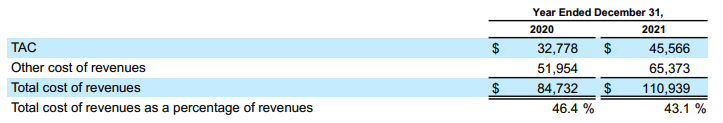

In [ ]:
# You can find a similar image as per the images you have in the metadata.
# In this case, you have a table (picked from the same document source) and you would like to find similar tables in the document.
image_query_path = "tac_table_revenue.png"

# Print a message indicating the input image
print("***Input image from user:***")

# Display the input image
Image.load_from_file(image_query_path)

You expect to find tables (as images) that are similar in terms of "Other/Total cost of revenues."


 **** Result: ***** 



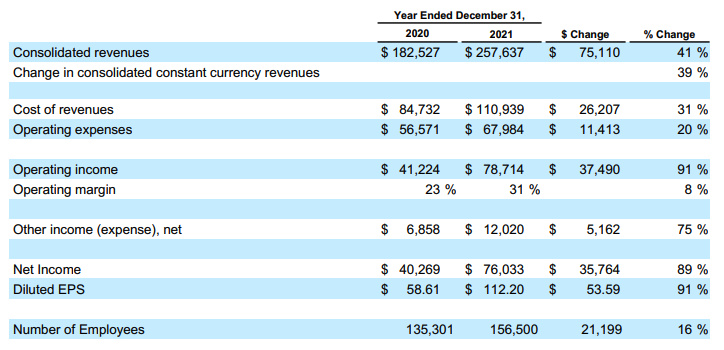

In [ ]:
# Search for Similar Images Based on Input Image and Image Embedding

matching_results_image = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,  # Use query text for additional filtering (optional)
    column_name="mm_embedding_from_img_only",  # Use image embedding for similarity calculation
    image_emb=True,
    image_query_path=image_query_path,  # Use input image for similarity calculation
    top_n=3,  # Retrieve top 3 matching images
    embedding_size=1408,  # Use embedding size of 1408
)

print("\n **** Result: ***** \n")

# Display the Top Matching Image
display(
    matching_results_image[0]["image_object"]
)  # Display the top matching image object (Pillow Image)

It did find a similar-looking image (table), which gives more detail about different revenue, expenses, income, and a few more details based on the given image. More importantly, both tables show numbers related to the "cost of revenue."

You can also print the citation to see what it has matched.

In [ ]:
# Display citation details for the top matching image
print_text_to_image_citation(
    matching_results_image, print_top=True
)  # Print citation details for the top matching image

Citation 1: Mached image path, page number and page text: 

score:  0.77
file_name:  google-10k-sample-part1.pdf
path:  images/google-10k-sample-part1.pdf_image_4_0_21.jpeg
page number:  5
page text:  Executive Overview
The following table summarizes consolidated financial results for the years ended
December 31, 2020 and 2021 unless otherwise specified (in millions, except for
per share information and percentages):
 Revenues were $257.6 billion, an increase of 41%. The increase in
revenues was primarily driven by Google Services and Google Cloud. The
adverse effect of COVID-19 on 2020 advertising revenues also contributed
to the year-over-year growth.
 Cost of revenues was $110.9 billion, an increase of 31%, primarily driven
by increases in TAC and content acquisition costs.
 An overall increase in data centers and other operations costs was partially
offset by a reduction in depreciation expense due to the change in the
estimated useful life of our servers and certain network equipm

---------------Matched Images------------------



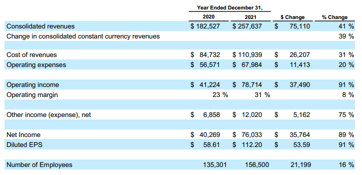

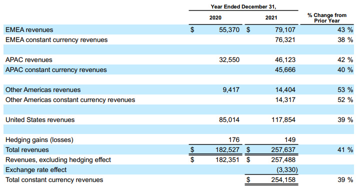

In [ ]:
# Check Other Matched Images (Optional)
# You can access the other two matched images using:

print("---------------Matched Images------------------\n")
display_images(
    [
        matching_results_image[0]["img_path"],
        matching_results_image[1]["img_path"],
    ],
    resize_ratio=0.5,
)

The ability to identify similar text and images based on user input, powered by Gemini and embeddings, forms a crucial foundation for development of multimodal RAG systems, which you explore in the next section.

### Comparative reasoning

Next, let's apply what you have done so far to doing comparative reasoning.

For this example:

Step 1: You will search all the images for a specific query

Step 2: Send those images to Gemini 1.0 Pro Vision to ask multiple questions, where it has to compare and provide you with answers.

In [ ]:
matching_results_image_query_1 = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query="Show me all the graphs that shows Google Class A cumulative 5-year total return",
    column_name="text_embedding_from_image_description",  # Use image description text embedding # mm_embedding_from_img_only text_embedding_from_image_description
    image_emb=False,  # Use text embedding instead of image embedding
    top_n=3,
    embedding_size=1408,
)

---------------Matched Images------------------



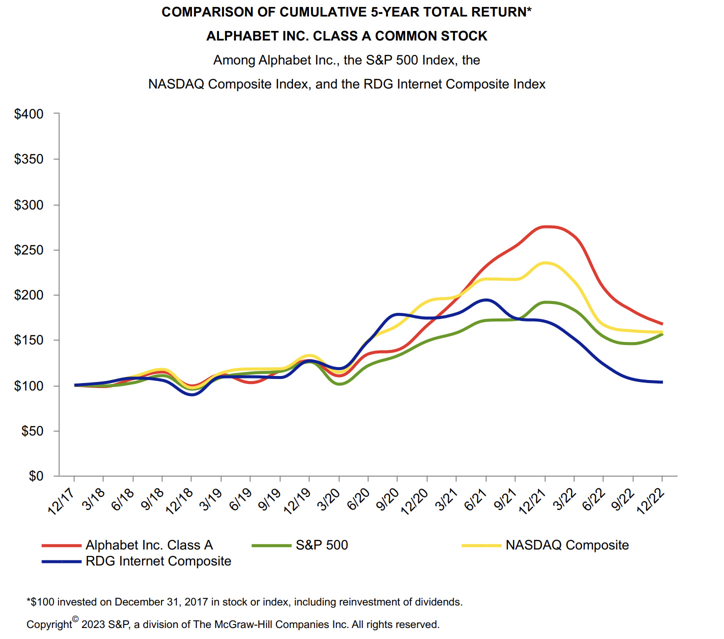

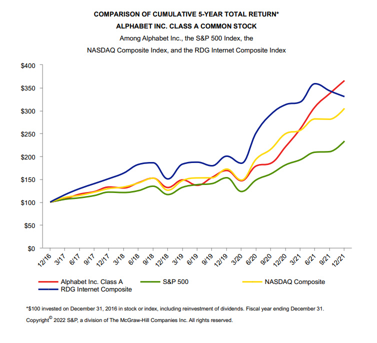

In [ ]:
# Check Matched Images
# You can access the other two matched images using:

print("---------------Matched Images------------------\n")
display_images(
    [
        matching_results_image_query_1[0]["img_path"],
        matching_results_image_query_1[1]["img_path"],
    ],
    resize_ratio=0.5,
)

In [ ]:
prompt = f""" Instructions: Compare the images and the Gemini extracted text provided as Context: to answer Question:
Make sure to think thoroughly before answering the question and put the necessary steps to arrive at the answer in bullet points for easy explainability.

Context:
Image_1: {matching_results_image_query_1[0]["image_object"]}
gemini_extracted_text_1: {matching_results_image_query_1[0]['image_description']}
Image_2: {matching_results_image_query_1[1]["image_object"]}
gemini_extracted_text_2: {matching_results_image_query_1[2]['image_description']}

Question:
 - Key findings of Class A share?
 - What are the critical differences between the graphs for Class A Share?
 - What are the key findings of Class A shares concerning the S&P 500?
 - Which index best matches Class A share performance closely where Google is not already a part? Explain the reasoning.
 - Identify key chart patterns in both graphs.
 - Which index best matches Class A share performance closely where Google is not already a part? Explain the reasoning.
"""

# Generate Gemini response with streaming output
Markdown(
    get_gemini_response(
        multimodal_model,
        model_input=[prompt],
        stream=True,
        generation_config=GenerationConfig(temperature=0.4, max_output_tokens=2048),
    )
)

1. **Key findings of Class A share?**
   - The cumulative 5-year total return of Alphabet Inc. Class A common stock outperformed the S&P 500 Index, the NASDAQ Composite Index, and the RDG Internet Composite Index.
   - Alphabet Inc. Class A common stock had the highest cumulative 5-year total return of 370.44%.

2. **What are the critical differences between the graphs for Class A Share?**
   - The cumulative 5-year total return of Alphabet Inc. Class A common stock was significantly higher than the S&P 500 Index, the NASDAQ Composite Index, and the RDG Internet Composite Index.
   - The cumulative 5-year total return of Alphabet Inc. Class A common stock was more volatile than the S&P 500 Index, the NASDAQ Composite Index, and the RDG Internet Composite Index.

3. **What are the key findings of Class A shares concerning the S&P 500?**
   - The cumulative 5-year total return of Alphabet Inc. Class A common stock outperformed the S&P 500 Index by a significant margin.
   - The cumulative 5-year total return of Alphabet Inc. Class A common stock was more volatile than the S&P 500 Index.

4. **Which index best matches Class A share performance closely where Google is not already a part? Explain the reasoning.**
   - The NASDAQ Composite Index best matches Class A share performance closely where Google is not already a part.
   - The NASDAQ Composite Index is a market-capitalization-weighted index of all Nasdaq-listed common stocks.
   - Google is a Nasdaq-listed company, so its performance is heavily influenced by the performance of the NASDAQ Composite Index.

5. **Identify key chart patterns in both graphs.**
   - **Image 1:**
     - The cumulative 5-year total return of Alphabet Inc. Class A common stock shows a strong uptrend.
     - The cumulative 5-year total return of the S&P 500 Index shows a moderate uptrend.
     - The cumulative 5-year total return of the NASDAQ Composite Index shows a moderate uptrend.
     - The cumulative 5-year total return of the RDG Internet Composite Index shows a moderate uptrend.
   - **Image 2:**
     - The number of unvested RSUs shows a downward trend.
     - The weighted-average grant-date fair value of unvested RSUs shows an upward trend.
     - The number of vested RSUs shows an upward trend.
     - The weighted-average grant-date fair value of vested RSUs shows an upward trend.
     - The number of forfeited or canceled RSUs shows a downward trend.
     - The weighted-average grant-date fair value of forfeited or canceled RSUs shows an upward trend.

6. **Which index best matches Class A share performance closely where Google is not already a part? Explain the reasoning.**
   - The NASDAQ Composite Index best matches Class A share performance closely where Google is not already a part.
   - The NASDAQ Composite Index is a market-capitalization-weighted index of all Nasdaq-listed common stocks.
   - Google is a Nasdaq-listed company, so its performance is heavily influenced by the performance of the NASDAQ Composite Index.


<div class="alert alert-block alert-warning">
<b>⚠️ Disclaimer: This is not a real investment advise and should not be taken seriously!! ⚠️</b>
</div>


## Multimodal retrieval augmented generation (RAG)

Let's bring everything together to implement multimodal RAG. You will use all the elements that you've explored in previous sections to implement the multimodal RAG. These are the steps:

* **Step 1:** The user gives a query in text format where the expected information is available in the document and is embedded in images and text.
* **Step 2:** Find all text chunks from the pages in the documents using a method similar to the one you explored in `Text Search`.
* **Step 3:** Find all similar images from the pages based on the user query matched with `image_description` using a method identical to the one you explored in `Image Search`.
* **Step 4:** Combine all similar text and images found in steps 2 and 3 as `context_text` and `context_images`.
* **Step 5:** With the help of Gemini, we can pass the user query with text and image context found in steps 2 & 3. You can also add a specific instruction the model should remember while answering the user query.
* **Step 6:** Gemini produces the answer, and you can print the citations to check all relevant text and images used to address the query.

### Step 1: User query

In [ ]:
# this time we are not passing any images, but just a simple text query.

query = """Questions:
 - What are the critical difference between various graphs for Class A Share?
 - Which index best matches Class A share performance closely where Google is not already a part? Explain the reasoning.
 - Identify key chart patterns for Google Class A shares.
 - What is cost of revenues, operating expenses and net income for 2020. Do mention the percentage change
 - What was the effect of Covid in the 2020 financial year?
 - What are the total revenues for APAC and USA for 2021?
 - What is deferred income taxes?
 - How do you compute net income per share?
 - What drove percentage change in the consolidated revenue and cost of revenue for the year 2021 and was there any effect of Covid?
 - What is the cause of 41% increase in revenue from 2020 to 2021 and how much is dollar change?
 """

### Step 2: Get all relevant text chunks

In [ ]:
# Retrieve relevant chunks of text based on the query
matching_results_chunks_data = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=10,
    chunk_text=True,
)

### Step 3: Get all relevant images

In [ ]:
# Get all relevant images based on user query
matching_results_image_fromdescription_data = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",
    image_emb=False,
    top_n=10,
    embedding_size=1408,
)

### Step 4: Create context_text and context_images

In [ ]:
# combine all the selected relevant text chunks
context_text = []
for key, value in matching_results_chunks_data.items():
    context_text.append(value["chunk_text"])
final_context_text = "\n".join(context_text)

# combine all the relevant images and their description generated by Gemini
context_images = []
for key, value in matching_results_image_fromdescription_data.items():
    context_images.extend(
        ["Image: ", value["image_object"], "Caption: ", value["image_description"]]
    )